In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [3]:
'''
optm: 'adam', 'GD'
activation: 'cross_entropy', 'relu', 'elu', 'leaky_relu'

By default: optm = 'adam'
            activation = 'cross_entropy'
'''
def multilayerPerceptron( Xtrain, Ytrain, Xtest, Ytest, n_class,
                            rate = 0.001, num_epoch = 100, num_batch = 500, optm = 'adam',
                            num_units = 14, activation = 'cross_entropy' ):
    
    print "Starting multilayer perceptron algorithm"
    print "Optimizer = ", optm
    print "learning_rate = ", rate
    print "batch size = ", num_batch
    print "num of epoch = ", num_epoch
    print "num of units = ", num_units
        
    # parameters
    learning_rate = rate
    training_epochs = num_epoch
    batch_size = num_batch
    
    # network parameters
    # 1st layer number of neurons
    n_hidden1 = num_units
    
    # 2nd layer number of neurons
    n_hidden2 = num_units
    
    # number of features
    n_input = 124
    
    n_classes = n_class
    
    # tf graph input
    X = tf.placeholder( "float", [ None, n_input ] )
    Y = tf.placeholder( "float", [ None, n_classes ] )
    
    # store layers weights and bias
    weights = {
        'h1' : tf.Variable( tf.random_normal( [ n_input, n_hidden1 ] ) ),
        'h2' : tf.Variable( tf.random_normal( [ n_hidden1, n_hidden2 ] ) ),
        'out' : tf.Variable( tf.random_normal( [ n_hidden2, n_classes ] ) )
    }
    biases = {
        'b1' : tf.Variable( tf.random_normal( [ n_hidden1 ] ) ),
        'b2' : tf.Variable( tf.random_normal( [ n_hidden2 ] ) ),
        'out' : tf.Variable( tf.random_normal( [ n_classes ] ) )
    }
    
    # constructing model
    logit = generate_model( X, weights, biases )
    
    # defining loss
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( logits = logit, labels = Y ) )
    
    if activation == 'relu':
        loss = tf.reduce_mean( tf.nn.relu( features = Y ) )
    elif activation == 'elu':
        loss = tf.reduce_mean( tf.nn.elu( features = Y ) )
    elif activation == 'leaky_relu':
        loss = tf.reduce_mean( tf.nn.leaky_relu( features = Y ) )
    
    # defining optimizer
    train = tf.train.AdamOptimizer(learning_rate).minimize( loss )
    
    if optm == 'GD':
        train = tf.train.GradientDescentOptimizer( learning_rate = learning_rate ).minimize( loss )
    
    # initializing the variables
    init = tf.global_variables_initializer()
    train_accuracy = np.array( [ 0 ] )
    test_accuracy = np.array( [ 0 ] )
    
    with tf.Session() as sess:
        sess.run( init )
        
        for epoch in range( training_epochs ):
            avg_cost = 0
            total_batch = int( Xtrain.shape[0] / batch_size )
            
            #print "epoch = ", epoch
            
            # loop over all batches
            for i in range( total_batch ):
                batch_x, batch_y = next_batch( batch_size, Xtrain, Ytrain )
                
                _, c = sess.run( [ train, loss ], feed_dict = { X: batch_x, Y: batch_y } )
                
                # computing average loss
                avg_cost += c / total_batch
                
            # test model
            pred = tf.nn.softmax( logit )
            correct_prediction = tf.equal( tf.argmax( pred, 1 ), tf.argmax( Y, 1 ) )
            
            # calculating accuracy
            accuracy = tf.reduce_mean( tf.cast( correct_prediction, "float" ) )
            train_acc = accuracy.eval( { X: Xtrain, Y: Ytrain } )
            test_acc = accuracy.eval( { X: Xtest, Y: Ytest } )
            
            test_accuracy = np.vstack( ( test_accuracy, test_acc ) )
            train_accuracy = np.vstack( ( train_accuracy, train_acc ) )
            
        n = 1
        plt.figure( n )
        plt.plot( train_accuracy )
        plt.title( "Training Accuracy vs Epoc" )
        plt.ylabel( "Accuracy" )
        plt.xlabel( "Epoc" )
        plt.grid()
        plt.show()
        n = n + 1
        
        plt.figure( n )
        plt.plot( test_accuracy )
        plt.title( "Testing Accuracy vs Epoc" )
        plt.ylabel( "Accuracy" )
        plt.xlabel( "Epoc" )
        plt.grid()
        plt.show()
        n = n + 1
        
        print "Final Training Accuracy of Classifier: ", np.amax( train_accuracy )
        print "Final Testing Accuracy of Classifier: ", np.amax( test_accuracy )

In [4]:
def generate_model( x, weights, biases ):
    # hidden fully connected layer 1 with 10 neurons
    layer_1 = tf.add( tf.matmul( x, weights[ 'h1'] ), biases[ 'b1' ] )
    
    # hidden fully connected layer 2 with 10 neurons
    layer_2 = tf.add( tf.matmul( layer_1, weights[ 'h2' ]), biases[ 'b2' ] )
    
    # output fully connected layer with a neuron from each class
    out_layer = tf.matmul( layer_2, weights[ 'out' ] ) + biases[ 'out' ]
    
    return out_layer

def next_batch( num, data, labels ):
    idx = np.arange( 0, len( data ) )
    np.random.shuffle( idx )
    idx = idx[:num]
    data_shuffle = [ data[i] for i in idx ]
    labels_shuffle = [ labels[i] for i in idx ]
    
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [5]:
# extracting asian dataset
csv1 = pd.read_csv("./marsyas_analysis/asian_features", delimiter = ',', comment = "%", skiprows=132).values
asian_features = csv1[:,0:-1]
asian_labels = csv1[:,-1]
asian_shape = asian_features.shape
asian_train = int( 4 * asian_shape[0] / 5 )

# extracting blues dataset
csv2 = pd.read_csv( "./marsyas_analysis/blues_features", delimiter = ',', comment = "%", skiprows=132).values
blues_features = csv2[:,0:-1]
blues_labels = csv2[:,-1]
blues_shape = blues_features.shape
blues_train = int(4 * blues_shape[0]/ 5 )

# extracting classical dataset
csv3 = pd.read_csv( "./marsyas_analysis/classical_features_total.csv", delimiter = ',', comment = "%", skiprows=132).values
classical_features = csv3[:,0:-1]
classical_labels = csv3[:,-1]
classical_shape = classical_features.shape
classical_train = int( 4 * classical_shape[0] / 5 )

# extracting country dataset
csv4 = pd.read_csv( "./marsyas_analysis/country_features_total.csv", delimiter = ',', comment = "%", skiprows=132).values
country_features = csv4[:,0:-1]
country_labels = csv4[:,-1]
country_shape = country_features.shape
country_train = int( 4 * country_shape[0] / 5 )

# extracting hip-hop dataset
csv5 = pd.read_csv( "./marsyas_analysis/hip_hop_features_total.csv", delimiter = ',', comment = "%", skiprows=132).values
hipHop_features = csv5[:,0:-1]
hipHop_labels = csv5[:,-1]
hipHop_shape = hipHop_features.shape
hipHop_train = int( 4 * hipHop_shape[0] / 5 )

# extracting pop dataset
csv6 = pd.read_csv( "./marsyas_analysis/pop_features_total.csv", delimiter = ',', comment = "%", skiprows=132).values
pop_features = csv6[:,0:-1]
pop_labels = csv6[:,-1]
pop_shape = pop_features.shape
pop_train = int( 4 * pop_shape[0] / 5 )

# extracting rock dataset
csv7 = pd.read_csv( "./marsyas_analysis/rock_features_total.csv", delimiter = ',', comment = "%", skiprows=132).values
rock_features = csv7[:,0:-1]
rock_labels = csv7[:,-1]
rock_shape = rock_features.shape
rock_train = int( 4 * rock_shape[0] / 5 )

print "asian_features = ", asian_features.shape
print "asian_labels = ", asian_labels.shape, "\n"

print "blues_features = ", blues_features.shape
print "blues_labels = ", blues_labels.shape, "\n"

print "classical features = ", classical_features.shape
print "classical labels = ", classical_labels.shape, "\n"

print "country features = ", country_features.shape
print "country labels = ", country_labels.shape, "\n"

print "hip-hop features = ", hipHop_features.shape
print "hip-hop labels = ", hipHop_labels.shape, "\n"

print "pop features = ", pop_features.shape
print "pop labels = ", pop_labels.shape, "\n"

print "rock features = ", rock_features.shape
print "rock labels = ", rock_labels.shape, "\n"



asian_features =  (106, 124)
asian_labels =  (106,) 

blues_features =  (132, 124)
blues_labels =  (132,) 

classical features =  (673, 124)
classical labels =  (673,) 

country features =  (696, 124)
country labels =  (696,) 

hip-hop features =  (691, 124)
hip-hop labels =  (691,) 

pop features =  (689, 124)
pop labels =  (689,) 

rock features =  (691, 124)
rock labels =  (691,) 



Running on all 5 classes
Xtrain =  (2749, 124)
Ytrain =  (2749, 5)

Xtest =  (691, 124)
Ytest =  (691, 5)
Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  100
num of epoch =  1000
num of units =  10


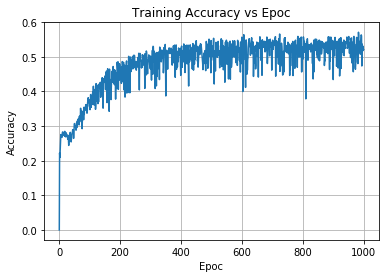

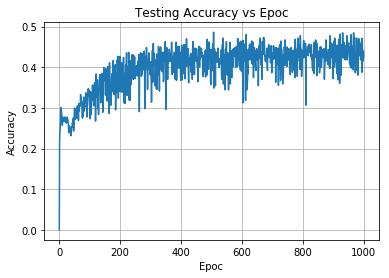

Final Training Accuracy of Classifier:  0.571116745472
Final Testing Accuracy of Classifier:  0.486251801252


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  500
num of epoch =  1000
num of units =  15


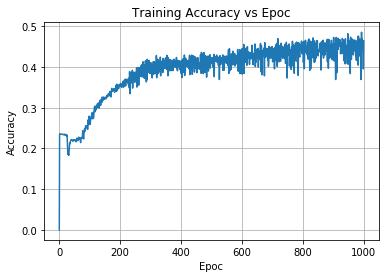

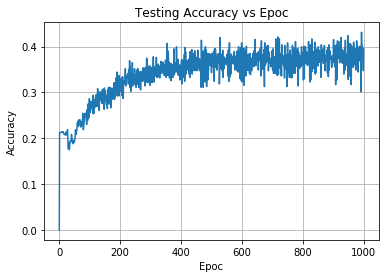

Final Training Accuracy of Classifier:  0.485267370939
Final Testing Accuracy of Classifier:  0.431259036064


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  1000
num of epoch =  1000
num of units =  20


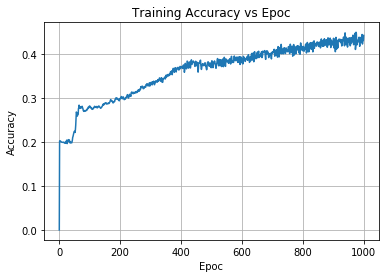

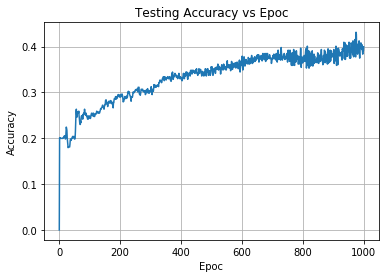

Final Training Accuracy of Classifier:  0.450709342957
Final Testing Accuracy of Classifier:  0.431259036064


In [5]:
# 5 class classification

# extracting training set
Xtrain = np.concatenate( ( classical_features[0:classical_train,:], country_features[0:country_train,:] ), axis = 0 )
Xtrain = np.concatenate( ( Xtrain[:,:], hipHop_features[0:hipHop_train,:] ), axis = 0 )
Xtrain = np.concatenate( ( Xtrain[:,:], pop_features[0:pop_train,:] ), axis = 0 )
Xtrain = np.concatenate( ( Xtrain[:,:], rock_features[0:rock_train,:] ), axis = 0 )

Ytrain = np.concatenate( ( classical_labels[0:classical_train], country_labels[0:country_train] ), axis = 0 )
Ytrain = np.concatenate( ( Ytrain[:], hipHop_labels[0:hipHop_train] ), axis = 0 )
Ytrain = np.concatenate( ( Ytrain[:], pop_labels[0:pop_train] ), axis = 0 )
Ytrain = np.concatenate( ( Ytrain[:], rock_labels[0:rock_train] ), axis = 0 )

# extracting testing set
Xtest = np.concatenate( ( classical_features[classical_train:,:], country_features[country_train:,:] ), axis = 0 )
Xtest = np.concatenate( ( Xtest, hipHop_features[hipHop_train:,:] ), axis = 0 )
Xtest = np.concatenate( ( Xtest, pop_features[pop_train:,:] ), axis = 0 )
Xtest = np.concatenate( ( Xtest, rock_features[rock_train:,:] ), axis = 0 )

Ytest = np.concatenate( ( classical_labels[classical_train:], country_labels[country_train:] ), axis = 0 )
Ytest = np.concatenate( ( Ytest, hipHop_labels[hipHop_train:] ), axis = 0 )
Ytest = np.concatenate( ( Ytest, pop_labels[pop_train:] ), axis = 0 )
Ytest = np.concatenate( ( Ytest, rock_labels[rock_train:] ), axis = 0 )

Ytrain = pd.get_dummies(Ytrain).as_matrix()
Ytest = pd.get_dummies(Ytest).as_matrix()

n_classes = 5

print "Running on all 5 classes"
print "Xtrain = ", Xtrain.shape
print "Ytrain = ", Ytrain.shape
print "\nXtest = ", Xtest.shape
print "Ytest = ", Ytest.shape

multilayerPerceptron( Xtrain, Ytrain, Xtest, Ytest, n_classes, optm = 'adam', num_epoch = 1000, num_units = 10, num_batch = 100 )
print "\n"
multilayerPerceptron( Xtrain, Ytrain, Xtest, Ytest, n_classes, optm = 'adam', num_epoch = 1000, num_units = 15, num_batch = 500 )
print "\n"
multilayerPerceptron( Xtrain, Ytrain, Xtest, Ytest, n_classes, optm = 'adam', num_epoch = 1000, num_units = 20, num_batch = 1000 )


Classical vs Country
Xtrain =  (1094, 124)
Ytrain =  (1094, 2)

Xtest =  (275, 124)
Ytest =  (275, 2)
Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  100
num of epoch =  1000
num of units =  10


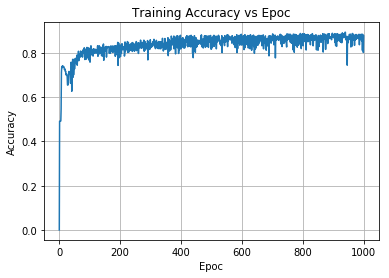

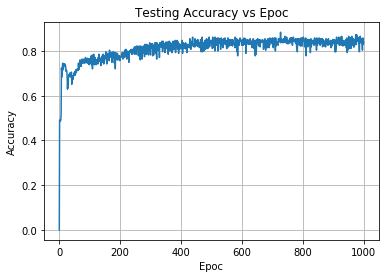

Final Training Accuracy of Classifier:  0.893967092037
Final Testing Accuracy of Classifier:  0.8836363554


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  500
num of epoch =  1000
num of units =  15


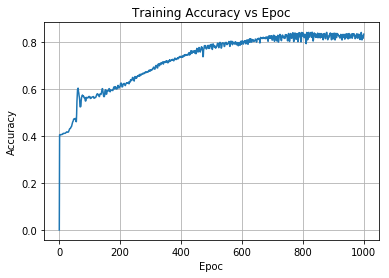

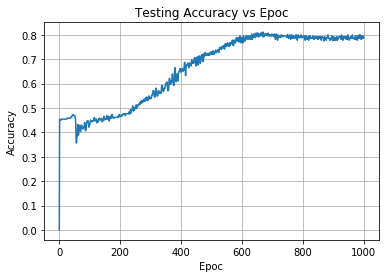

Final Training Accuracy of Classifier:  0.840036571026
Final Testing Accuracy of Classifier:  0.810909092426


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  1000
num of epoch =  1000
num of units =  20


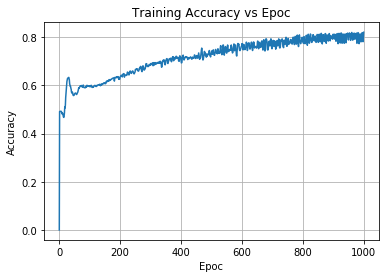

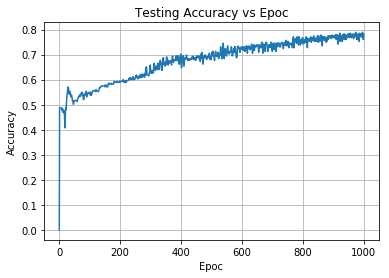

Final Training Accuracy of Classifier:  0.820840954781
Final Testing Accuracy of Classifier:  0.789090931416


In [ ]:
# classical vs country
Xtrain1 = np.concatenate( ( classical_features[0:classical_train,:], country_features[0:country_train,:] ), axis = 0 )
Ytrain1 = np.concatenate( ( classical_labels[0:classical_train], country_labels[0:country_train] ), axis = 0 )
Xtest1 = np.concatenate( ( classical_features[classical_train:,:], country_features[country_train:,:] ), axis = 0 )
Ytest1 = np.concatenate( ( classical_labels[classical_train:], country_labels[country_train:] ), axis = 0 )

Ytrain1 = pd.get_dummies(Ytrain1).as_matrix()
Ytest1 = pd.get_dummies(Ytest1).as_matrix()

n_classes = 2

print "Classical vs Country"
print "Xtrain = ", Xtrain1.shape
print "Ytrain = ", Ytrain1.shape
print "\nXtest = ", Xtest1.shape
print "Ytest = ", Ytest1.shape

multilayerPerceptron( Xtrain1, Ytrain1, Xtest1, Ytest1, n_classes, optm = 'adam', num_epoch = 1000, num_units = 10, num_batch = 100 )
print "\n"
multilayerPerceptron( Xtrain1, Ytrain1, Xtest1, Ytest1, n_classes, optm = 'adam', num_epoch = 1000, num_units = 15, num_batch = 500 )
print "\n"
multilayerPerceptron( Xtrain1, Ytrain1, Xtest1, Ytest1, n_classes, optm = 'adam', num_epoch = 1000, num_units = 20, num_batch = 1000 )


Classical vs Hip-Hop
Xtrain =  (1090, 124)
Ytrain =  (1090, 2)

Xtest =  (274, 124)
Ytest =  (274, 2)
Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  100
num of epoch =  1000
num of units =  10


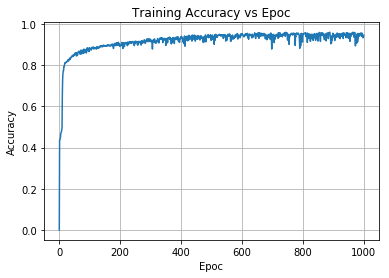

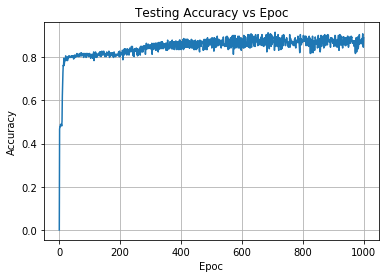

Final Training Accuracy of Classifier:  0.960550487041
Final Testing Accuracy of Classifier:  0.916058421135


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  500
num of epoch =  1000
num of units =  15


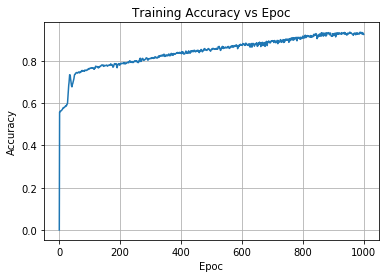

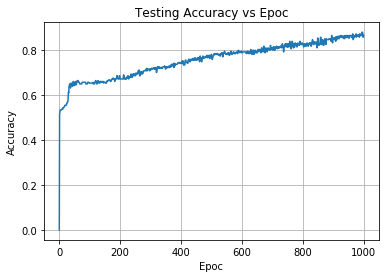

Final Training Accuracy of Classifier:  0.935779809952
Final Testing Accuracy of Classifier:  0.879562020302


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  1000
num of epoch =  1000
num of units =  20


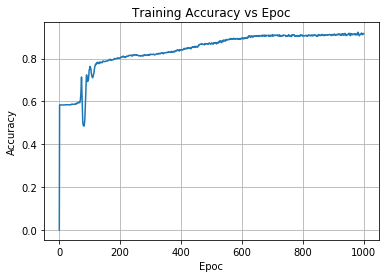

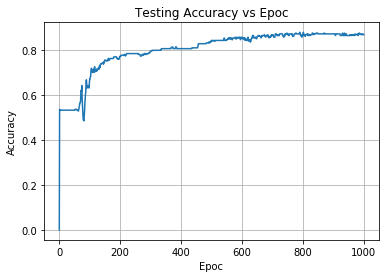

Final Training Accuracy of Classifier:  0.922935783863
Final Testing Accuracy of Classifier:  0.879562020302


In [6]:
# classical vs hip-hop
Xtrain2 = np.concatenate( ( classical_features[0:classical_train,:], hipHop_features[0:hipHop_train,:] ), axis = 0 )
Ytrain2 = np.concatenate( ( classical_labels[0:classical_train], hipHop_labels[0:hipHop_train] ), axis = 0 )
Xtest2 = np.concatenate( ( classical_features[classical_train:,:], hipHop_features[hipHop_train:,:] ), axis = 0 )
Ytest2 = np.concatenate( ( classical_labels[classical_train:], hipHop_labels[hipHop_train:] ), axis = 0 )

Ytrain2 = pd.get_dummies(Ytrain2).as_matrix()
Ytest2 = pd.get_dummies(Ytest2).as_matrix()

n_classes = 2

print "Classical vs Hip-Hop"
print "Xtrain = ", Xtrain2.shape
print "Ytrain = ", Ytrain2.shape
print "\nXtest = ", Xtest2.shape
print "Ytest = ", Ytest2.shape

multilayerPerceptron( Xtrain2, Ytrain2, Xtest2, Ytest2, n_classes, optm = 'adam', num_epoch = 1000, num_units = 10, num_batch = 100 )
print "\n"
multilayerPerceptron( Xtrain2, Ytrain2, Xtest2, Ytest2, n_classes, optm = 'adam', num_epoch = 1000, num_units = 15, num_batch = 500 )
print "\n"
multilayerPerceptron( Xtrain2, Ytrain2, Xtest2, Ytest2, n_classes, optm = 'adam', num_epoch = 1000, num_units = 20, num_batch = 1000 )


Classical vs Pop
Xtrain =  (1089, 124)
Ytrain =  (1089, 2)

Xtest =  (273, 124)
Ytest =  (273, 2)
Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  100
num of epoch =  1000
num of units =  10


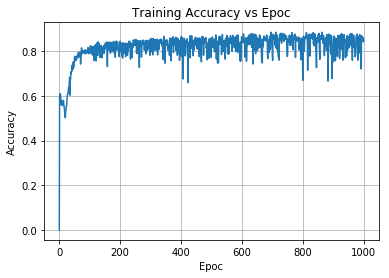

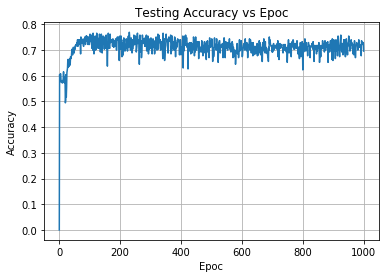

Final Training Accuracy of Classifier:  0.884297549725
Final Testing Accuracy of Classifier:  0.769230782986


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  500
num of epoch =  1000
num of units =  15


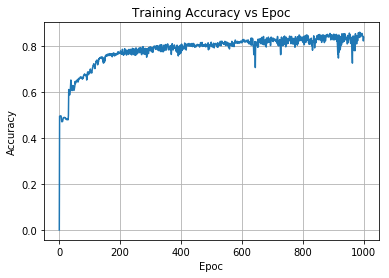

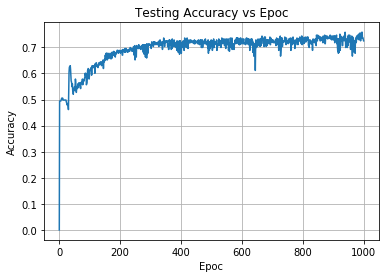

Final Training Accuracy of Classifier:  0.858585834503
Final Testing Accuracy of Classifier:  0.758241772652


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  1000
num of epoch =  1000
num of units =  20


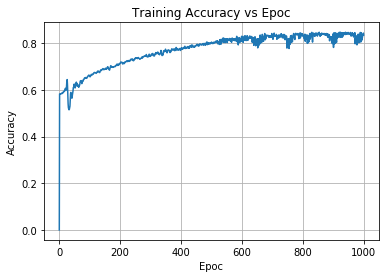

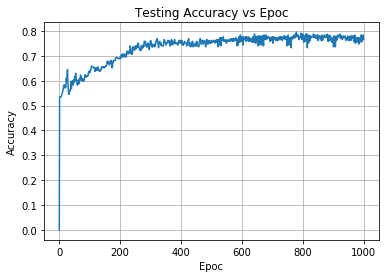

Final Training Accuracy of Classifier:  0.847566604614
Final Testing Accuracy of Classifier:  0.794871807098


In [8]:
# classical vs pop
Xtrain3 = np.concatenate( ( classical_features[0:classical_train,:], pop_features[0:pop_train,:] ), axis = 0 )
Ytrain3 = np.concatenate( ( classical_labels[0:classical_train], pop_labels[0:pop_train] ), axis = 0 )
Xtest3 = np.concatenate( ( classical_features[classical_train:,:], pop_features[pop_train:,:] ), axis = 0 )
Ytest3 = np.concatenate( ( classical_labels[classical_train:], pop_labels[pop_train:] ), axis = 0 )

Ytrain3 = pd.get_dummies(Ytrain3).as_matrix()
Ytest3 = pd.get_dummies(Ytest3).as_matrix()

n_classes = 2

print "Classical vs Pop"
print "Xtrain = ", Xtrain3.shape
print "Ytrain = ", Ytrain3.shape
print "\nXtest = ", Xtest3.shape
print "Ytest = ", Ytest3.shape

multilayerPerceptron( Xtrain3, Ytrain3, Xtest3, Ytest3, n_classes, optm = 'adam', num_epoch = 1000, num_units = 10, num_batch = 100 )
print "\n"
multilayerPerceptron( Xtrain3, Ytrain3, Xtest3, Ytest3, n_classes, optm = 'adam', num_epoch = 1000, num_units = 15, num_batch = 500 )
print "\n"
multilayerPerceptron( Xtrain3, Ytrain3, Xtest3, Ytest3, n_classes, optm = 'adam', num_epoch = 1000, num_units = 20, num_batch = 1000 )


Classical vs Rock
Xtrain =  (1090, 124)
Ytrain =  (1090, 2)

Xtest =  (274, 124)
Ytest =  (274, 2)
Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  100
num of epoch =  1000
num of units =  10


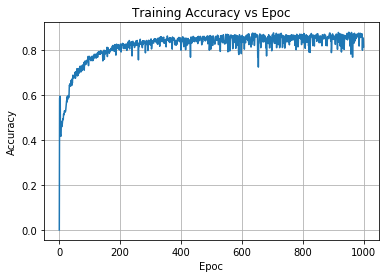

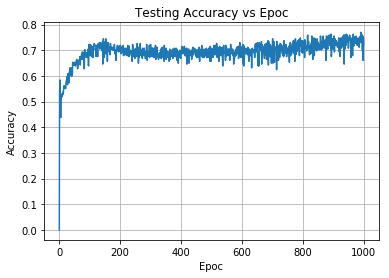

Final Training Accuracy of Classifier:  0.879816532135
Final Testing Accuracy of Classifier:  0.770072996616


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  500
num of epoch =  1000
num of units =  15


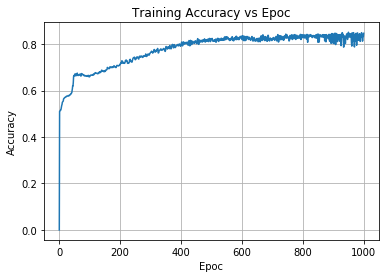

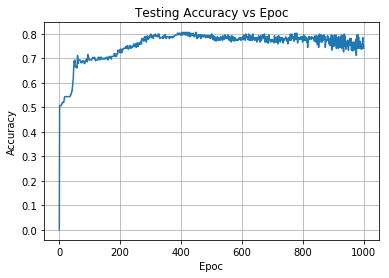

Final Training Accuracy of Classifier:  0.85137617588
Final Testing Accuracy of Classifier:  0.806569337845


Starting multilayer perceptron algorithm
Optimizer =  adam
learning_rate =  0.001
batch size =  1000
num of epoch =  1000
num of units =  20


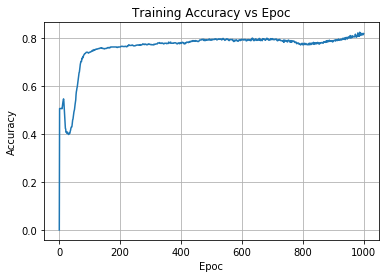

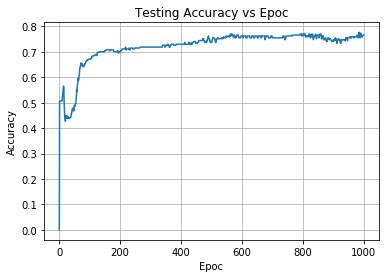

Final Training Accuracy of Classifier:  0.824770629406
Final Testing Accuracy of Classifier:  0.77737224102


In [10]:
# classical vs rock
Xtrain4 = np.concatenate( ( classical_features[0:classical_train,:], rock_features[0:rock_train,:] ), axis = 0 )
Ytrain4 = np.concatenate( ( classical_labels[0:classical_train], rock_labels[0:rock_train] ), axis = 0 )
Xtest4 = np.concatenate( ( classical_features[classical_train:,:], rock_features[rock_train:,:] ), axis = 0 )
Ytest4 = np.concatenate( ( classical_labels[classical_train:], rock_labels[rock_train:] ), axis = 0 )

Ytrain4 = pd.get_dummies(Ytrain4).as_matrix()
Ytest4 = pd.get_dummies(Ytest4).as_matrix()

n_classes = 2

print "Classical vs Rock"
print "Xtrain = ", Xtrain4.shape
print "Ytrain = ", Ytrain4.shape
print "\nXtest = ", Xtest4.shape
print "Ytest = ", Ytest4.shape

multilayerPerceptron( Xtrain4, Ytrain4, Xtest4, Ytest4, n_classes, optm = 'adam', num_epoch = 1000, num_units = 10, num_batch = 100 )
print "\n"
multilayerPerceptron( Xtrain4, Ytrain4, Xtest4, Ytest4, n_classes, optm = 'adam', num_epoch = 1000, num_units = 15, num_batch = 500 )
print "\n"
multilayerPerceptron( Xtrain4, Ytrain4, Xtest4, Ytest4, n_classes, optm = 'adam', num_epoch = 1000, num_units = 20, num_batch = 1000 )
